# Prepare GPS data 

In [1]:
# load GPS data
import pandas as pd
from datetime import datetime
import time
from shapely.geometry import Point
import geopandas as gpd


crs = {'init': 'epsg:4326'}
to_crs = {'init': 'epsg:3395'}


def load_gps_data_melbourne(file, crs, to_crs):
    print('loading Melbourne GPS Trajectory')
    gps_track = pd.read_csv(file, 
                            header=None, 
                            names=['timestamp', 'lat', 'lon'], 
                            skiprows=[0], 
                            delim_whitespace=True)
    gps_track['geometry'] = gps_track.apply(lambda row: Point(row['lon'], row['lat']), axis=1)
    gps_track['gps'] = gps_track['geometry']
    gps_track = gpd.GeoDataFrame(gps_track, crs=crs)
    gps_track.to_crs(to_crs, inplace=True)
    return gps_track


def load_GPS_data_Seattle(file, crs, to_crs):
    print('loading Seattle GPS Trajectory')
    gps_track = pd.read_csv(file,
                            header=None,
                            names=['Data(UTC)', 'Time(UTC)', 'lat', 'lon'],
                            skiprows=[0],
                            delim_whitespace=True)
    # string to datatime
    gps_track['datatime'] = gps_track.apply(
        lambda row: datetime.strptime(row['Data(UTC)'] + ' ' + row['Time(UTC)'], '%d-%b-%Y %H:%M:%S'), axis=1)
    gps_track.drop(['Data(UTC)', 'Time(UTC)'], axis=1, inplace=True)
    # datatime to unix time
    gps_track['timestamp'] = gps_track.apply(lambda row: time.mktime(row['datatime'].timetuple()), axis=1)
    gps_track['geometry'] = gps_track.apply(lambda row: Point(row['lon'], row['lat']), axis=1)
    gps_track = gpd.GeoDataFrame(gps_track, crs=crs)
    gps_track.to_crs(to_crs, inplace=True)
    return gps_track


gps_track = load_GPS_data_Seattle('./data/Seattle/gps_data.txt', crs, to_crs)
#gps_track = load_gps_data_melbourne('./data/Melbourne/gps_track.txt', crs, to_crs)
gps_track.head()

loading Seattle GPS Trajectory


,lat,lon,datatime,timestamp,geometry
0,47.667483,-122.107083,2009-01-17 20:27:37,1.232195e+09,POINT (-13592898.33520784 6020110.32713188)
1,47.667500,-122.107067,2009-01-17 20:27:38,1.232195e+09,POINT (-13592896.48730429 6020113.074315307)
2,47.667500,-122.107067,2009-01-17 20:27:39,1.232195e+09,POINT (-13592896.48730429 6020113.074315307)
3,47.667517,-122.107033,2009-01-17 20:27:40,1.232195e+09,POINT (-13592892.7692333 6020115.821499617)
4,47.667533,-122.106983,2009-01-17 20:27:41,1.232195e+09,POINT (-13592887.20325876 6020118.56703683)


# load road network data

Seattle 路网数据需要进行清理。主要有两种情况需要清理：
- 部分路段只有一个GPS坐标点(即两个点的坐标一样)，需要将这种路段清除。
- 部分节点具有相同的GPS坐标，但是节点的id不相同，即本属于同一路口的节点被命名为不同的id。但是，也有GPS坐标相同，但其实属于不同路口的情况。需要合并id，让相连的路段连通。

**注意：对DataFrame类型的数据执行行删除后，通过索引访问数据，即iloc()，会出问题，原因需进一步弄清楚，是索引的更新？？？？**

In [2]:
import pandas as pd
import geopandas as gpd
import shapely.wkt
from shapely.geometry import LineString, Point
import networkx as nx


## http://wikicode.wikidot.com/get-angle-of-line-between-two-points
## angle between two points
def calculate_bearing(pt1, pt2):
    import math
    x_diff = pt2.x - pt1.x
    y_diff = pt2.y - pt1.y
    bearing = math.degrees(math.atan2(y_diff, x_diff))
    if bearing < 0:
        return bearing + 360
    else:
        return bearing

def heading_difference(A, B):
    d = max(A,B)-min(A,B)
    if d > 180:
        d=360-d
    return d


def max_speed(road_type):
    if road_type == 1:
        return 100
    elif road_type == 2:
        return 60
    elif road_type == 3:
        return 50
    elif road_type == 4:
        return 50
    elif road_type == 5:
        return 80
    elif road_type == 6:
        return 30
    else:
        return 40
    
def load_road_network(filename, crs, to_crs):
    print('loading Melbourne Road Network ...')
    road = pd.read_csv(filename, 
                        header=None, 
                        names=['Edge_ID','from', 'from lon', 'from lat', 
                               'to', 'to lon', 'to lat',
                               'length', 'road type', 'bearing'], 
                        skiprows=[0], 
                        sep=' ')
    road['geometry'] = road.apply(lambda row: 
                                  LineString([(row['from lon'], row['from lat']), (row['to lon'], row['to lat'])]), axis=1)
    road['max speed'] = road.apply(lambda row: max_speed(row['road type']), axis=1)
    road['gps'] = road['geometry']
    road = gpd.GeoDataFrame(road, crs=crs, geometry='geometry')
    # coordinate transformation
    road.to_crs(to_crs, inplace=True)
    road['bbox'] = road.apply(lambda row: row['geometry'].bounds, axis=1)
    road_graph = nx.from_pandas_edgelist(
        pd.DataFrame(road, columns=('Edge_ID', 'from', 'to', 'gps', 'geometry', 'max speed', 'length', 'bbox')), 
                                     'from', 
                                     'to', 
                                     ['Edge_ID', 'max speed', 'geometry', 'length'], 
                                     create_using=nx.MultiDiGraph())
    return road, road_graph
    

def remove_edges_with_single_point(road):
    index_list = []
    for row_index, row in road.iterrows():  
        if row['geometry'].coords[0] == row['geometry'].coords[-1] and 2==len(row['geometry'].coords):
            index_list.append(row_index)
    road.drop(index_list, inplace=True)
    #road.reset_index()
    print('Removed edges with single point: ')
    print index_list
    #column_names = ['Edge_ID', 'from', 'to', 'two_way', 'max speed', 'vertex_count', 'geometry']
    #return pd.DataFrame(road.values, columns=column_names )

     
    
def get_nodes_id_coordinate_dict(road):
    nodes_dict = {} # key: node_id, value: a list (the gps coordinate of the node, edge_ids....)
    for row_index, row in road.iterrows():
        start_point = row['geometry'].coords[0]
        start_node_id = row['from']
        if nodes_dict.has_key(start_node_id):
            if nodes_dict[start_node_id][0] != start_point:
                print(start_node_id, nodes_dict[start_node_id], (start_point, row_index))
            nodes_dict[start_node_id].append(row_index)
        else:
            nodes_dict[start_node_id] = [start_point, row_index]
        end_point = row['geometry'].coords[-1]
        end_node_id = row['to']
        if nodes_dict.has_key(end_node_id):
            if nodes_dict[end_node_id][0] != end_point:
                print(end_node_id, nodes_dict[end_node_id], (end_point, row_index))
            nodes_dict[end_node_id].append(row_index)
        else:
            nodes_dict[end_node_id] = [end_point, row_index]
    print('There are %d nodes in the road network!' % len(nodes_dict))
    return nodes_dict

    
def get_nodes_coordinate_id_dict(nodes_dict):
    point_id_dict = {}  # key: a gps coordinate, value: a tuple (edge_id, node_id)
    for node_id, value in nodes_dict.items():
        point = value[0]
        edge_index_list = value[1:]
        if point_id_dict.has_key(point):
            point_id_dict[point].append((edge_index_list, node_id))
        else:
            point_id_dict[point] = [(edge_index_list, node_id)]
    return point_id_dict


def get_nodes_with_different_ids(road):
    nodes_dict = get_nodes_id_coordinate_dict(road)       
    point_id_dict = get_nodes_coordinate_id_dict(nodes_dict)
    nodes_with_different_ids = []
    #id_dict = {}
    for point, value in point_id_dict.items():
        if len(value) > 1:
            nodes_with_different_ids.append(value)
            #for i in range(len(value)): 
            #    id_list = []
            #    for j in range(len(value)):
            #        if j != i:
            #            id_list.append(value[j])
            #    id_dict[value[i][1]] = id_list
    return nodes_with_different_ids #, id_dict
    

def combine_same_nodes(road, nodes_with_different_ids):
    road_values = road.values
    for i in range(len(nodes_with_different_ids)):
        final_node_id = nodes_with_different_ids[i][0][1]
        ind_list = []
        node_id_ind = 0
        for j in range(len(nodes_with_different_ids[i])):
            edge_id_list = nodes_with_different_ids[i][j][0]
            node_id = nodes_with_different_ids[i][j][1]
            if len(edge_id_list) < 2:
                ind_list.append(j)
            else:
                if len(edge_id_list) > len(nodes_with_different_ids[i][0][0]):
                    final_node_id = node_id
                    node_id_ind = j
        print i, final_node_id, ind_list
        # update node ids        
        for k in ind_list:
            if k != node_id_ind:
                node_id = nodes_with_different_ids[i][k][1]
                edge_id_list = nodes_with_different_ids[i][k][0]
                for edge_id in edge_id_list:
                    from_node_id = road.iloc[edge_id]['from']
                    to_node_id = road.iloc[edge_id]['to']    
                    print edge_id, from_node_id, to_node_id, node_id
                    if from_node_id == node_id:                   
                        road_values[edge_id][1] = final_node_id
                        print('Change %d to %d in edge %d ' % (node_id, final_node_id, edge_id))
                    elif to_node_id == node_id:           
                        road_values[edge_id][2] = final_node_id
                        print('Change %d to %d in edge %d ' % (node_id, final_node_id, edge_id))
                    else:
                        print('Node %d is not in edge %d.'%(node_id, edge_id))
    column_names = ['Edge_ID', 'from', 'to', 'two_way', 'max speed', 'vertex_count', 'geometry']
    return pd.DataFrame(road_values, columns=column_names )
                
    
def load_road_network_seattle(filename, crs, to_crs):
    """
    prepare Seattle road network data
    :param filename:
    :param crs:
    :param to_crs
    :return:
    """
    print('loading Seattle Road Network ...')
    #column_names = ['Edge_ID', 'From_Node_ID', 'To_Node_ID', 'Two_Way', 'Speed(m/s)', 'Vertex_Count', 'geometry']
    column_names = ['Edge_ID', 'from', 'to', 'two_way', 'max speed', 'vertex_count', 'geometry']
    road = pd.read_csv(filename, header=None, names=column_names, skiprows=[0], sep='\t')
    road['geometry'] = road.apply(lambda row: shapely.wkt.loads(row['geometry']), axis=1)       
    # filtering road network data
    
    # update node ids
    nodes_with_different_ids = get_nodes_with_different_ids(road)
    road = combine_same_nodes(road, nodes_with_different_ids)
    remove_edges_with_single_point(road)
    #print road.values.shape, updated_road.values.shape
    
    # coordinates transformation
    road = gpd.GeoDataFrame(road, crs=crs, geometry='geometry')
    road.to_crs(to_crs, inplace=True)
    road['length'] = road.apply(lambda row: row['geometry'].length, axis=1)
    road['bbox'] = road.apply(lambda row: row['geometry'].bounds, axis=1)
    #print len(road)
    direct_edges_list = []
    idx = 0
    for row_index, row in road.iterrows():
        direct_edges_list.append([idx, row['Edge_ID'], row['from'], row['to'],
                                  row['max speed'], row['geometry'], row['length'], row['bbox'], 1])
        idx = idx+1
        if 1 == row['two_way']:
            direct_edges_list.append([idx, row['Edge_ID'], row['to'], row['from'],
                                      row['max speed'], LineString(list(row['geometry'].coords)[::-1]),
                                     row['length'], row['bbox'], 0])
            idx = idx+1
    edges = pd.DataFrame(
        direct_edges_list,
        columns=('Edge_ID', 'osm_edge_id', 'from', 'to', 'max speed', 'geometry', 'length', 'bbox', 'from_to'))
    edges['bearing'] = \
        edges.apply(lambda edge:
                    calculate_bearing(Point(edge['geometry'].coords[0]), Point(edge['geometry'].coords[1])), axis=1)
    #nodes_with_different_ids, id_dict = get_nodes_with_different_ids(edges)
    road_graph = nx.from_pandas_edgelist(edges,
                                         'from',
                                         'to',
                                         ['Edge_ID', 'max speed', 'geometry', 'length'],
                                         create_using=nx.MultiDiGraph())
    # print len(edges)
    # print len(direct_edges_list)
    return road_graph, gpd.GeoDataFrame(edges, crs=to_crs, geometry='geometry'), nodes_with_different_ids #, id_dict


import time
start_time = time.time()
road_graph, edges_gpd, nodes_with_different_ids = load_road_network_seattle('./data/Seattle/road_network.txt', crs, to_crs)
# edges_gpd, road_graph = load_road_network('./data/Melbourne/complete-osm-map/streets.txt', crs, to_crs)
print("--- %s seconds ---" % (time.time() - start_time))

loading Seattle Road Network ...
There are 133460 nodes in the road network!
0 884147900470 [0, 1]
125414 884149000087 884149000088 884149000087
Change 884149000087 to 884147900470 in edge 125414 
1 884147303357 [0, 1]
69112 884147204512 884147203934 884147204512
Change 884147204512 to 884147303357 in edge 69112 
2 884131101391 [0, 1]
60063 884133300006 884133300007 884133300007
Change 884133300007 to 884131101391 in edge 60063 
3 884147503086 [0, 1]
87640 884147800237 884147800238 884147800237
Change 884147800237 to 884147503086 in edge 87640 
4 884147200049 [0, 1]
12630 884010601362 884010601354 884010601362
Change 884010601362 to 884147200049 in edge 12630 
5 884133000055 [0, 1]
55457 884132800565 884132800566 884132800565
Change 884132800565 to 884133000055 in edge 55457 
6 884147800094 [0, 1]
86477 884147601790 884147601791 884147601790
Change 884147601790 to 884147800094 in edge 86477 
7 884148000836 []
8 884148100354 []
9 884147500236 [0, 1]
80775 884147405152 884147405153 88414

200 884012200073 [0, 1]
24069 884011100386 884011100387 884011100386
Change 884011100386 to 884012200073 in edge 24069 
201 884150900146 [0, 1]
157336 884152000043 884152000042 884152000043
Change 884152000043 to 884150900146 in edge 157336 
202 884148300837 []
203 884148800571 [0, 1]
125380 884149000046 884149000047 884149000047
Change 884149000047 to 884148800571 in edge 125380 
204 884147300126 [0, 1]
65216 884147201443 884147201439 884147201443
Change 884147201443 to 884147300126 in edge 65216 
205 884148700151 [0, 1]
120520 884148502448 884148502449 884148502448
Change 884148502448 to 884148700151 in edge 120520 
206 884150403020 [0, 1]
133235 884150500322 884150500323 884150500322
Change 884150500322 to 884150403020 in edge 133235 
207 884012200105 [0, 1]
24203 884011100503 884011100304 884011100503
Change 884011100503 to 884012200105 in edge 24203 
208 884150900354 [0, 1]
150126 884151100044 884151100045 884151100045
Change 884151100045 to 884150900354 in edge 150126 
209 884148

341 884150403017 [0, 1]
133232 884150500318 884150500319 884150500319
Change 884150500319 to 884150403017 in edge 133232 
342 884011000581 [0, 1]
84581 884147600015 884147600016 884147600016
Change 884147600016 to 884011000581 in edge 84581 
343 884129800035 [0, 1]
28347 884129600189 884129600186 884129600189
Change 884129600189 to 884129800035 in edge 28347 
344 884148303435 [0, 1]
133217 884150500003 884150500302 884150500302
Change 884150500302 to 884148303435 in edge 133217 
345 884148200380 [0, 1]
100404 884148005536 884148005537 884148005536
Change 884148005536 to 884148200380 in edge 100404 
346 884148200283 [0, 1]
98613 884148004670 884148004055 884148004670
Change 884148004670 to 884148200283 in edge 98613 
347 884150900104 [0, 1]
146326 884150801439 884150801440 884150801440
Change 884150801440 to 884150900104 in edge 146326 
348 884148000038 []
349 884147300250 [0, 1]
69107 884147204508 884147204507 884147204508
Change 884147204508 to 884147300250 in edge 69107 
350 88414820

100660 884148100001 884148100013 884148100013
Change 884148100013 to 884147500374 in edge 100660 
511 884151000970 [0, 1]
150211 884151100150 884151100151 884151100151
Change 884151100151 to 884151000970 in edge 150211 
512 884147402027 []
513 884128700360 [0, 1]
27482 884129300086 884129300087 884129300087
Change 884129300087 to 884128700360 in edge 27482 
514 884011000015 [0, 1]
16121 884010700646 884010700647 884010700647
Change 884010700647 to 884011000015 in edge 16121 
515 884147404988 [0, 1]
93067 884148000343 884148000344 884148000343
Change 884148000343 to 884147404988 in edge 93067 
516 884149100058 [0, 1]
125953 884149000568 884149000569 884149000568
Change 884149000568 to 884149100058 in edge 125953 
517 884150900006 [0, 1]
123325 884148700237 884148700235 884148700237
Change 884148700237 to 884150900006 in edge 123325 
518 884147400143 [0, 1]
68359 884147203994 884147203995 884147203994
Change 884147203994 to 884147400143 in edge 68359 
519 884130901956 [0, 1]
93306 884148

21708 884010900104 884010900105 884010900104
Change 884010900104 to 884010801035 in edge 21708 
658 884150700122 [0, 1]
136605 884150503187 884150501816 884150503187
Change 884150503187 to 884150700122 in edge 136605 
659 884133400202 [0, 1]
61223 884133500030 884133500031 884133500030
Change 884133500030 to 884133400202 in edge 61223 
660 884011000093 [0, 1]
19317 884010703482 884010703480 884010703482
Change 884010703482 to 884011000093 in edge 19317 
661 884149900038 [0, 1]
127295 884149800115 884149800116 884149800115
Change 884149800115 to 884149900038 in edge 127295 
662 884130600172 [0, 1]
54917 884132800048 884132800049 884132800049
Change 884132800049 to 884130600172 in edge 54917 
663 884148300133 [0, 1]
103886 884148102830 884148102667 884148102830
Change 884148102830 to 884148300133 in edge 103886 
664 884130303721 [0, 1]
74032 884147400615 884147400616 884147400616
Change 884147400616 to 884130303721 in edge 74032 
665 884147403256 [0, 1]
92892 884148000097 884148000158 88

31260 884129900035 884129900029 884129900035
Change 884129900035 to 884130500016 in edge 31260 
782 884130200001 [0, 1]
31314 884129900090 884129900091 884129900090
Change 884129900090 to 884130200001 in edge 31314 
783 884130100001 [0, 1]
2207 883993500003 883993500000 883993500003
Change 883993500003 to 884130100001 in edge 2207 
784 883993500085 [0, 1]
11229 884010600072 884010600073 884010600072
Change 884010600072 to 883993500085 in edge 11229 
785 884130000057 [0, 1]
32275 884130100069 884130100070 884130100069
Change 884130100069 to 884130000057 in edge 32275 
786 884148000697 []
787 884130600283 [0, 1]
46788 884130700079 884130700078 884130700079
Change 884130700079 to 884130600283 in edge 46788 
788 884147800051 [0, 1]
86227 884147601557 884147601553 884147601557
Change 884147601557 to 884147800051 in edge 86227 
789 884147300136 [0, 1]
65431 884147201640 884147201639 884147201640
Change 884147201640 to 884147300136 in edge 65431 
790 884150900110 [0, 1]
146494 884150801587 88

1556 883993300000 883993300001 883993300001
Change 883993300001 to 883992700038 in edge 1556 
918 884133100117 [0, 1]
57084 884133000546 884133000174 884133000546
Change 884133000546 to 884133100117 in edge 57084 
919 884148300265 [0, 1]
107641 884148201200 884148202872 884148202872
Change 884148202872 to 884148300265 in edge 107641 
920 884012200095 [0, 1]
24168 884011100474 884011100469 884011100474
Change 884011100474 to 884012200095 in edge 24168 
921 884010400399 [0, 1]
7813 884010500412 884010500413 884010500413
Change 884010500413 to 884010400399 in edge 7813 
922 884150700188 [0, 1]
140822 884150603199 884150603200 884150603200
Change 884150603200 to 884150700188 in edge 140822 
923 884150900474 [0, 1]
157360 884152000074 884152000075 884152000075
Change 884152000075 to 884150900474 in edge 157360 
924 884147300213 [0, 1]
68340 884147203978 884147203980 884147203980
Change 884147203980 to 884147300213 in edge 68340 
925 884147402856 []
926 884010800074 [0, 1]
5471 884010201073 

40239 884130303623 884130301941 884130303623
Change 884130303623 to 884130900256 in edge 40239 
1055 884130100293 [0, 1]
63886 884147200215 884147200236 884147200236
Change 884147200236 to 884130100293 in edge 63886 
1056 884150700616 []
1057 884148303038 [0, 1]
120847 884148600161 884148600162 884148600162
Change 884148600162 to 884148303038 in edge 120847 
1058 884150700438 [0, 1]
154791 884151300009 884151300010 884151300010
Change 884151300010 to 884150700438 in edge 154791 
1059 884131101977 [0, 1]
104800 884148200595 884148200596 884148200596
Change 884148200596 to 884131101977 in edge 104800 
1060 884148800527 [0, 1]
125373 884149000039 884149000040 884149000040
Change 884149000040 to 884148800527 in edge 125373 
1061 884148100319 []
1062 884148302280 [0, 1]
120826 884148600131 884148600132 884148600132
Change 884148600132 to 884148302280 in edge 120826 
1063 884010603139 [0, 1]
63814 884147200153 884147200154 884147200154
Change 884147200154 to 884010603139 in edge 63814 
1064 

1197 884148200064 [0, 1]
95040 884148002155 884148002151 884148002155
Change 884148002155 to 884148200064 in edge 95040 
1198 884129300446 [0, 1]
41241 884130400185 884130400138 884130400185
Change 884130400185 to 884129300446 in edge 41241 
1199 884149600079 [0, 1]
118495 884148500665 884148500657 884148500665
Change 884148500665 to 884149600079 in edge 118495 
1200 884148301738 [0, 1]
133000 884150500055 884150500056 884150500056
Change 884150500056 to 884148301738 in edge 133000 
1201 884130900393 [0, 1]
93158 884148000447 884148000443 884148000447
Change 884148000447 to 884130900393 in edge 93158 
1202 884147404045 [0, 1]
92936 884148000204 884148000205 884148000205
Change 884148000205 to 884147404045 in edge 92936 
1203 884148300122 [0, 1]
103881 884148102824 884148101284 884148102824
Change 884148102824 to 884148300122 in edge 103881 
1204 884147900311 [0, 1]
117858 884148500025 884148500026 884148500026
Change 884148500026 to 884147900311 in edge 117858 
1205 884148100096 [0, 1]

25755 884012600081 884012600082 884012600081
Change 884012600081 to 884012300308 in edge 25755 
1356 884131700476 [0, 1]
54964 884132800115 884132800086 884132800115
Change 884132800115 to 884131700476 in edge 54964 
1357 884128700600 [0, 1]
29828 884129800158 884129800136 884129800158
Change 884129800158 to 884128700600 in edge 29828 
1358 884148303006 [0, 1]
133060 884150500132 884150500133 884150500133
Change 884150500133 to 884148303006 in edge 133060 
1359 884130500484 [0, 1]
47723 884130800063 884130800064 884130800064
Change 884130800064 to 884130500484 in edge 47723 
1360 884147401860 [0, 1]
92865 884148000129 884148000130 884148000130
Change 884148000130 to 884147401860 in edge 92865 
1361 884130304012 [0, 1]
48250 884130900340 884130900341 884130900340
Change 884130900340 to 884130304012 in edge 48250 
1362 884148400566 []
1363 884133500323 [0, 1]
137273 884150600136 884150600137 884150600136
Change 884150600136 to 884133500323 in edge 137273 
1364 884150701330 [0, 1]
148127 

72562 884147303110 884147303107 884147303110
Change 884147303110 to 884147500165 in edge 72562 
1518 884147500174 [0, 1]
72567 884147303117 884147303097 884147303117
Change 884147303117 to 884147500174 in edge 72567 
1519 884151000215 [0, 1]
144282 884150702558 884150702559 884150702558
Change 884150702558 to 884151000215 in edge 144282 
1520 884130600995 [0, 1]
46854 884130700164 884130700165 884130700164
Change 884130700164 to 884130600995 in edge 46854 
1521 884147900516 [0, 1]
117874 884148500042 884148500044 884148500044
Change 884148500044 to 884147900516 in edge 117874 
1522 884148700113 [0, 1]
120315 884148502276 884148501842 884148502276
Change 884148502276 to 884148700113 in edge 120315 
1523 884147800637 [0, 1]
91482 884147900121 884147900122 884147900122
Change 884147900122 to 884147800637 in edge 91482 
1524 884010700120 [0, 1]
10623 884010502478 884010502479 884010502478
Change 884010502478 to 884010700120 in edge 10623 
1525 884129200114 [0, 1]
27513 884129300121 8841293

1660 884147400157 [0, 1]
68368 884147204003 884147204002 884147204003
Change 884147204003 to 884147400157 in edge 68368 
1661 884150900095 [0, 1]
146275 884150800532 884150801389 884150801389
Change 884150801389 to 884150900095 in edge 146275 
1662 883993100170 [0, 1]
2176 883993400017 883993400016 883993400017
Change 883993400017 to 883993100170 in edge 2176 
1663 884010800860 [0, 1]
21695 884010900085 884010900086 884010900086
Change 884010900086 to 884010800860 in edge 21695 
1664 884147400216 [0, 1]
68698 884147204202 884147204186 884147204202
Change 884147204202 to 884147400216 in edge 68698 
1665 884150403008 [0, 1]
133227 884150500310 884150500311 884150500310
Change 884150500310 to 884150403008 in edge 133227 
1666 884129700100 [0, 1]
31247 884129900017 884129900018 884129900018
Change 884129900018 to 884129700100 in edge 31247 
1667 884147500131 [0, 1]
72537 884147303085 884147301146 884147303085
Change 884147303085 to 884147500131 in edge 72537 
1668 884150900082 [0, 1]
14534

150241 884151100191 884151100192 884151100192
Change 884151100192 to 884151001341 in edge 150241 
1794 884131700316 [0, 1]
54957 884132800105 884132800106 884132800105
Change 884132800105 to 884131700316 in edge 54957 
1795 884150402560 [0, 1]
133196 884150500277 884150500278 884150500277
Change 884150500277 to 884150402560 in edge 133196 
1796 884150700208 [0, 1]
140828 884150603206 884150603209 884150603209
Change 884150603209 to 884150700208 in edge 140828 
1797 884150700000 [0, 1]
133118 884150500192 884150500195 884150500195
Change 884150500195 to 884150700000 in edge 133118 
1798 884148001860 []
1799 884152300008 [0, 1]
157643 884152200053 884152200054 884152200053
Change 884152200053 to 884152300008 in edge 157643 
1800 884010200965 [0, 1]
20293 884010800015 884010800016 884010800016
Change 884010800016 to 884010200965 in edge 20293 
1801 884150702948 []
1802 884148201800 []
1803 884150702025 [0, 1]
154857 884151300085 884151300086 884151300086
Change 884151300086 to 88415070202

109122 884148203861 884148203618 884148203861
Change 884148203861 to 884150400137 in edge 109122 
1908 884148001792 []
1909 884148000675 []
1910 884012300005 [0, 1]
24493 884012100029 884012100030 884012100029
Change 884012100029 to 884012300005 in edge 24493 
1911 884130900006 []
1912 884147300192 [0, 1]
67488 884147203302 884147203295 884147203302
Change 884147203302 to 884147300192 in edge 67488 
1913 884151000289 [0, 1]
150164 884151100095 884151100096 884151100095
Change 884151100095 to 884151000289 in edge 150164 
1914 884148303203 [0, 1]
120893 884148600214 884148600215 884148600215
Change 884148600215 to 884148303203 in edge 120893 
1915 884147800597 [0, 1]
91478 884147900116 884147900117 884147900117
Change 884147900117 to 884147800597 in edge 91478 
1916 884148302284 [0, 1]
120827 884148600133 884148600134 884148600134
Change 884148600134 to 884148302284 in edge 120827 
1917 884148000402 []
1918 884130100860 [0, 1]
63965 884147200326 884147200327 884147200326
Change 884147200

Change 884151100010 to 884150900193 in edge 150090 
2067 884012300040 [0, 1]
25708 884012600019 884012600020 884012600019
Change 884012600019 to 884012300040 in edge 25708 
2068 884148001862 []
2069 884130901842 [0, 1]
93256 884148000540 884148000541 884148000541
Change 884148000541 to 884130901842 in edge 93256 
2070 884130902045 [0, 1]
93307 884148000589 884148000380 884148000589
Change 884148000589 to 884130902045 in edge 93307 
2071 884147400267 [0, 1]
35349 884130300290 884130300291 884130300291
Change 884130300291 to 884147400267 in edge 35349 
73707 884147400266 884147400267 884147400266
Change 884147400266 to 884147400267 in edge 73707 
2072 884130101971 [0, 1]
64054 884147200416 884147200074 884147200416
Change 884147200416 to 884130101971 in edge 64054 
2073 884130100412 [0, 1]
63923 884147200279 884147200277 884147200279
Change 884147200279 to 884130100412 in edge 63923 
2074 884150200673 [0, 1]
157994 884152400018 884152400019 884152400019
Change 884152400019 to 88415020067

146804 884150801855 884150801854 884150801855
Change 884150801855 to 884150900121 in edge 146804 
2227 884148800631 [0, 1]
125298 884148900016 884148900017 884148900016
Change 884148900016 to 884148800631 in edge 125298 
2228 884010400395 [0, 1]
7808 884010500407 884010500408 884010500408
Change 884010500408 to 884010400395 in edge 7808 
2229 884147900621 [0, 1]
117876 884148500045 884148500046 884148500046
Change 884148500046 to 884147900621 in edge 117876 
2230 884010701381 [0, 1]
69151 884147300047 884147300048 884147300048
Change 884147300048 to 884010701381 in edge 69151 
2231 884148200258 [0, 1]
97247 884148003786 884148003776 884148003786
Change 884148003786 to 884148200258 in edge 97247 
2232 884148300043 [0, 1]
101957 884148101271 884148101263 884148101271
Change 884148101271 to 884148300043 in edge 101957 
2233 884147303101 [0, 2]
80940 884147500157 884147500158 884147500158
Change 884147500158 to 884147303101 in edge 80940 
72554 884147303102 884147303101 884147303102
Change

2382 884010800445 [0, 1]
21676 884010900062 884010900063 884010900063
Change 884010900063 to 884010800445 in edge 21676 
2383 884130500100 [0, 1]
41788 884130400676 884130400694 884130400694
Change 884130400694 to 884130500100 in edge 41788 
2384 884010801055 [0, 1]
21720 884010900120 884010900121 884010900120
Change 884010900120 to 884010801055 in edge 21720 
2385 884150501988 [0, 1]
144847 884150800092 884150800093 884150800093
Change 884150800093 to 884150501988 in edge 144847 
2386 883993500209 [0, 1]
32255 884130100010 884130100044 884130100044
Change 884130100044 to 883993500209 in edge 32255 
2387 884150600590 [0, 1]
141419 884150700162 884150700164 884150700164
Change 884150700164 to 884150600590 in edge 141419 
2388 884150500145 []
2389 884131100133 [0, 1]
104279 884148200001 884148200004 884148200004
Change 884148200004 to 884131100133 in edge 104279 
2390 884130102068 [0, 1]
35149 884130300078 884130300083 884130300083
Change 884130300083 to 884130102068 in edge 35149 
2391 

2534 884010703133 [0, 1]
69181 884147300086 884147300088 884147300088
Change 884147300088 to 884010703133 in edge 69181 
2535 884130500326 [0, 1]
46728 884130700003 884130700004 884130700004
Change 884130700004 to 884130500326 in edge 46728 
2536 884148300086 [0, 1]
103314 884148102366 884148102354 884148102366
Change 884148102366 to 884148300086 in edge 103314 
2537 884133100130 [0, 1]
57147 884133000612 884133000613 884133000612
Change 884133000612 to 884133100130 in edge 57147 
2538 884150900462 [0, 1]
157350 884152000062 884152000063 884152000062
Change 884152000062 to 884150900462 in edge 157350 
2539 884148402564 [0, 1]
117948 884148500137 884148500138 884148500137
Change 884148500137 to 884148402564 in edge 117948 
2540 884148100307 [0, 1]
113725 884148400170 884148400171 884148400171
Change 884148400171 to 884148100307 in edge 113725 
2541 884147303351 [0, 1]
84666 884147600127 884147600128 884147600128
Change 884147600128 to 884147303351 in edge 84666 
2542 884128700112 [0, 1]

9553 884010501696 884010501692 884010501696
Change 884010501696 to 884010700093 in edge 9553 
2697 884150503279 [0, 1]
144892 884150800161 884150800162 884150800162
Change 884150800162 to 884150503279 in edge 144892 
2698 884009900108 []
2699 884147800179 [0, 1]
83206 884147502114 884147502115 884147502114
Change 884147502114 to 884147800179 in edge 83206 
2700 884149700022 [0, 1]
126509 884149600319 884149600320 884149600319
Change 884149600319 to 884149700022 in edge 126509 
2701 884010700224 [0, 1]
12777 884010601491 884010601492 884010601491
Change 884010601491 to 884010700224 in edge 12777 
2702 883992700250 [0, 1]
1606 883993300054 883993300055 883993300055
Change 883993300055 to 883992700250 in edge 1606 
2703 884148001985 []
2704 884148300135 [0, 1]
104061 884148102947 884148102948 884148102947
Change 884148102947 to 884148300135 in edge 104061 
2705 884148001465 []
2706 884131101988 [0, 1]
104808 884148200607 884148200608 884148200608
Change 884148200608 to 884131101988 in edg

67485 884147203298 884147203299 884147203299
Change 884147203299 to 884147300189 in edge 67485 
2849 884147800170 [0, 1]
83126 884147500272 884147502057 884147502057
Change 884147502057 to 884147800170 in edge 83126 
2850 884010400595 [0, 1]
11222 884010600061 884010600062 884010600062
Change 884010600062 to 884010400595 in edge 11222 
2851 884147802314 [0, 1]
113690 884148400127 884148400128 884148400128
Change 884148400128 to 884147802314 in edge 113690 
2852 884012200063 [0, 1]
24005 884011100332 884011100333 884011100332
Change 884011100332 to 884012200063 in edge 24005 
2853 884147500201 []
2854 884150400327 [0, 1]
133105 884150500182 884150500183 884150500182
Change 884150500182 to 884150400327 in edge 133105 
2855 884130300023 [0, 1]
32588 884130100366 884130100367 884130100366
Change 884130100366 to 884130300023 in edge 32588 
2856 884147301988 [0, 1]
84632 884147600078 884147600080 884147600080
Change 884147600080 to 884147301988 in edge 84632 
2857 884010800030 [0, 1]
5379 88

2971 884147404023 [0, 1]
92910 884148000175 884148000176 884148000176
Change 884148000176 to 884147404023 in edge 92910 
2972 884129200081 [0, 1]
27509 884129300116 884129300117 884129300116
Change 884129300116 to 884129200081 in edge 27509 
2973 884148100167 []
2974 883991900051 [0, 1]
26058 884128500019 884128500022 884128500022
Change 884128500022 to 883991900051 in edge 26058 
2975 884150700120 [0, 1]
136601 884150503183 884150503184 884150503183
Change 884150503183 to 884150700120 in edge 136601 
2976 884132900116 [0, 1]
55410 884132800516 884132800517 884132800517
Change 884132800517 to 884132900116 in edge 55410 
2977 884150503502 [0, 1]
144895 884150800165 884150800166 884150800166
Change 884150800166 to 884150503502 in edge 144895 
2978 884148300326 [0, 1]
120787 884148600074 884148600075 884148600075
Change 884148600075 to 884148300326 in edge 120787 
2979 884010702298 [0, 1]
69155 884147300055 884147300056 884147300056
Change 884147300056 to 884010702298 in edge 69155 
2980 

84584 884147600021 884147600022 884147600022
Change 884147600022 to 884011000663 in edge 84584 
3103 884147500207 [0, 1]
75626 884147402005 884147402006 884147402006
Change 884147402006 to 884147500207 in edge 75626 
3104 884148700198 [0, 1]
120718 884148502611 884148502610 884148502611
Change 884148502611 to 884148700198 in edge 120718 
3105 884130900404 [0, 1]
93161 884148000451 884148000449 884148000451
Change 884148000451 to 884130900404 in edge 93161 
3106 884129700493 [0, 1]
31961 884130000050 884130000051 884130000051
Change 884130000051 to 884129700493 in edge 31961 
3107 884148600064 [0, 1]
117673 884148403529 884148403530 884148403529
Change 884148403529 to 884148600064 in edge 117673 
3108 884149600035 [0, 1]
125605 884149000279 884149000280 884149000279
Change 884149000279 to 884149600035 in edge 125605 
3109 884148400212 [0, 1]
101847 884148101174 884148101175 884148101175
Change 884148101175 to 884148400212 in edge 101847 
3110 884009900645 [0, 1]
4339 884010200061 884010

60663 884133400138 884133400139 884133400138
Change 884133400138 to 884133101056 in edge 60663 
3225 884150401746 [0, 1]
137211 884150600056 884150600057 884150600057
Change 884150600057 to 884150401746 in edge 137211 
3226 884131100231 [0, 1]
50849 884130902201 884130901643 884130902201
Change 884130902201 to 884131100231 in edge 50849 
3227 884130303257 [0, 1]
74000 884147400575 884147400576 884147400575
Change 884147400575 to 884130303257 in edge 74000 
3228 884148303193 [0, 1]
120878 884148600195 884148600197 884148600197
Change 884148600197 to 884148303193 in edge 120878 
3229 884128700645 [0, 1]
29838 884129800168 884129800169 884129800168
Change 884129800168 to 884128700645 in edge 29838 
3230 884130401326 [0, 1]
44367 884130500136 884130500137 884130500136
Change 884130500136 to 884130401326 in edge 44367 
3231 884148100202 []
3232 884147501228 [0, 1]
100686 884148100040 884148100041 884148100041
Change 884148100041 to 884147501228 in edge 100686 
3233 884130600104 [0, 1]
54878

Removed edges with single point: 
[15542, 72554, 73707, 73724, 73733, 73992, 82116, 82591, 93144, 93234, 93308, 93315, 101094, 105459, 106440, 113270, 129176]
--- 130.721000195 seconds ---


In [3]:
len(nodes_with_different_ids)

3378

In [4]:
nodes_with_different_ids[0:5]

[[([91831], 884147900470L), ([125414], 884149000087L)],
 [([72855], 884147303357L), ([69112], 884147204512L)],
 [([53287], 884131101391L), ([60063], 884133300007L)],
 [([84328], 884147503086L), ([87640], 884147800237L)],
 [([63724], 884147200049L), ([12630], 884010601362L)]]

# Trajectory segmentation

In [5]:
# OBR Calculation
from shapely.geometry import Point
def obr(track, d_error, min_num_points):
    # create initial rectangle
    clusters = []
    outliers = []
    removed = []
    anchor = [False for i in range(len(track))]
    cluster = [0,1]    
    c1 = track.iloc[cluster[0]]['geometry'].buffer(d_error).exterior
    for i in range(2, len(track)):        
        c2 = track.iloc[i]['geometry'].buffer(d_error).exterior
        mbr_new = c1.union(c2).minimum_rotated_rectangle
        possible_outliers = []
        for item in cluster[1:]:
            if not mbr_new.contains(track.iloc[item]['geometry']):
                anchor[item] = True
                possible_outliers.append(item)
        # remove outliers
        j = 0
        while j < len(possible_outliers):
            if anchor[possible_outliers[j]-1] == False and anchor[possible_outliers[j]+1] ==False:
                outliers.append(possible_outliers[j])
                cluster.remove(possible_outliers[j])
                possible_outliers.remove(possible_outliers[j])                
            else:
                j=j+1
        if len(possible_outliers) > 0:            
            # divide current cluster into two parts          
            ind = cluster.index(possible_outliers[-1])
            first_part = [cluster[k] for k in range(ind+1)]
            second_part = [cluster[k] for k in range(ind,len(cluster))]
            #print possible_outliers
            #print first_part
            #print second_part            
            #print '-----'
            if len(first_part) > min_num_points:
                clusters.append(first_part)
            else:
                removed.append(first_part)
            cluster = second_part
            cluster.append(i)
            c1 = track.iloc[cluster[0]]['geometry'].buffer(d_error).exterior 
        else:
            cluster.append(i)
    if len(cluster) > min_num_points:
        clusters.append(cluster)     
    return clusters, outliers, removed       


#d_error = 10
#clusters, outliers, removed = obr(gps_track, d_error, 2)
#len(clusters), len(outliers), len(removed)

In [6]:
def calculate_heading_difference(edges_gpd, edge_id, mbr, mbr_heading):
    import shapely
    edge_bearing = edges_gpd.iloc[edge_id]['bearing']
    a = edges_gpd.iloc[edge_id]['geometry'].difference(mbr)
    if isinstance(a, shapely.geometry.multilinestring.MultiLineString):
        p1 = shapely.geometry.Point(list(a.geoms)[0].coords[-1])
        p2 = shapely.geometry.Point(list(a.geoms)[1].coords[0])
        edge_bearing = calculate_bearing(p1, p2)
    elif isinstance(a, shapely.geometry.LineString):
        if a.coords[0] == edges_gpd.iloc[edge_id]['geometry'].coords[0] and a.coords[-1] == edges_gpd.iloc[edge_id]['geometry'].coords[-1]:
            pass
        elif a.coords[0] == edges_gpd.iloc[edge_id]['geometry'].coords[0]:
            p1 = shapely.geometry.Point(a.coords[-1])
            p2 = shapely.geometry.Point(edges_gpd.iloc[edge_id]['geometry'].coords[-1])
            edge_bearing = calculate_bearing(p1, p2)
        else:
            p1 = shapely.geometry.Point(edges_gpd.iloc[edge_id]['geometry'].coords[0])
            p2 = shapely.geometry.Point(a.coords[0])
            edge_bearing = calculate_bearing(p1, p2)
    else:
        if a.is_empty:
            pass
        else:
            print type(a)
    diff = heading_difference(mbr_heading, edge_bearing)
    return diff


def filter_edges(mbr, mbr_heading, edges_gpd, edges, a_error):    
    flag = [True for i in range(len(edges))]
    count = 0
    for i in range(len(edges)):
        diff = calculate_heading_difference(edges_gpd, edges[i], mbr, mbr_heading)
        if diff > a_error:
            flag[i] = False
            count = count+1
    new_edges = []
    for i in range(len(flag)):
        if flag[i]:
            new_edges.append(edges[i])
    return new_edges


def filter_routes(routes):
    flag = [True for i in range(len(routes))]
    for i in range(len(routes)-1):
        for j in range(i+1,len(routes)):
            if flag[i] and flag[j]:
                if len(routes[i]) < len(routes[j]):
                    if (routes[i][0] in routes[j]) and (routes[i][-1] in routes[j]):
                        ind_1 = routes[j].index(routes[i][0])
                        ind_2 = routes[j].index(routes[i][-1])
                        if ind_2-ind_1+1 == len(routes[i]):
                            flag[i] = False
                            break
                else:
                    if (routes[j][0] in routes[i]) and (routes[j][-1] in routes[i]):
                        ind_1 = routes[i].index(routes[j][0])
                        ind_2 = routes[i].index(routes[j][-1])
                        if ind_2-ind_1+1 == len(routes[j]):
                            flag[j] = False
    new_routes=[]
    for i in range(len(flag)):
        if flag[i]: 
            new_routes.append(routes[i])
    return new_routes


def filter_duplicate_routes(routes):
    flag = [True for i in range(len(routes))]
    for i in range(len(routes)-1):
        for j in range(i+1,len(routes)):
            if flag[i] or flag[j]:
                if len(routes[i]) < len(routes[j]):
                    if (routes[i][0] in routes[j]) and (routes[i][-1] in routes[j]):
                        ind_1 = routes[j].index(routes[i][0])
                        ind_2 = routes[j].index(routes[i][-1])
                        if ind_2-ind_1+1 == len(routes[i]):
                            flag[j] = False
                else:
                    if (routes[j][0] in routes[i]) and (routes[j][-1] in routes[i]):
                        ind_1 = routes[i].index(routes[j][0])
                        ind_2 = routes[i].index(routes[j][-1])
                        if ind_2-ind_1+1 == len(routes[j]):
                            flag[i] = False
    new_routes=[]
    for i in range(len(flag)):
        if flag[i]: 
            new_routes.append(routes[i])
    return new_routes


def calculate_shortest_path(road_graph, edges_gpd, start_edge_id, end_edge_id):
    route = []
    if start_edge_id == end_edge_id:
        route.append(start_edge_id)
    elif edges_gpd.iloc[start_edge_id]['to'] == edges_gpd.iloc[end_edge_id]['from']:
        route.append(start_edge_id)
        route.append(end_edge_id)
    else:
        source = edges_gpd.iloc[start_edge_id]['to']
        target = edges_gpd.iloc[end_edge_id]['from']
        try:
            #net_distance = nx.shortest_path_length(road_graph, source, target, weight='length')
            sp = nx.shortest_path(road_graph, source, target, weight='length')
        except Exception as err:
            print('No route from %d to %d' % (source, target))
        else:    
            route.append(start_edge_id)
            for i in range(1, len(sp)):
                route.append(road_graph[sp[i-1]][sp[i]][0]['Edge_ID'])
            route.append(end_edge_id)
    return route


def save_to_file_candidate_routes(filename, candidates):
    with open(filename, 'w') as fwritter:
        for i in range(len(candidates)):
            fwritter.write('%d:\n' % i)
            candidate_routes = candidates.iloc[i]['candidate_routes']
            # print candidate_routes
            obs_prob = candidates.iloc[i]['obs_prob']
            # print obs_prob
            for j in range(len(candidate_routes)):
                for edge_id in candidate_routes[j]:
                    fwritter.write('%d, ' % edge_id)
                fwritter.write('[%f]' % obs_prob[j])
                fwritter.write('\n')
            fwritter.write('\n')

            
def save_to_file_transit_routes(filename, candidates):
    with open(filename, 'w') as fWriter:
        for idx in range(1, len(candidates)):
            fWriter.write('%d to %d:\n' % (candidates.iloc[idx]['pre_cluster'], idx))
            possible_paths = candidates.iloc[idx]['tran_routes']
            tran_prob = candidates.iloc[idx]['tran_prob']
            distances = candidates.iloc[idx]['distances']
            for i in range(len(possible_paths)):                
                for j in range(len(possible_paths[i])):                    
                    #for k in range(len(possible_paths[i][j])):                    
                    for edge_id in possible_paths[i][j]:
                        fWriter.write('%d, ' % edge_id)
                    fWriter.write('[%f, %f, %f]\n' % (distances[i][j][0], distances[i][j][1], tran_prob[i][j]))
            fWriter.write('\n') 
            
            
def map_osm_edge_id(edges_gpd, opt_route):
    opt_route_osm_edge_id = []
    for edge_id in opt_route:
        opt_route_osm_edge_id.append((edges_gpd.iloc[edge_id]['osm_edge_id'],edges_gpd.iloc[edge_id]['from_to']))
    return opt_route_osm_edge_id


def save_to_file_matching_result_seattle(filename, opt_route):
    with open(filename, 'w') as fwritter:
        fwritter.write('%d\n' % len(opt_route))
        for i in range(len(opt_route)):
            fwritter.write('%d\t%d\n' % (opt_route[i][0], opt_route[i][1]))

# Query candidate edges and routes

In [7]:
def query_edges_by_point_range(edges_gpd, point, diameter):
    from shapely.ops import nearest_points
    edge_ids = list(edges_gpd.sindex.intersection(point.buffer(diameter).exterior.bounds, objects='raw'))
    edge_id_list = []
    for edge_id in edge_ids:
        edge = edges_gpd.iloc[edge_id]
        results = nearest_points(point, edge['geometry'])
        d = point.distance(results[1])
        if d <= diameter:
            edge_id_list.append(edge['Edge_ID'])       
    return edge_id_list


def calculate_observation_probability(edges_gpd, routes, mbr, mbr_heading):
    import shapely
    obs_prob = []
    for route in routes:
        diff_sum = 0.0
        for edge_id in route:
            diff = calculate_heading_difference(edges_gpd, edge_id, mbr, mbr_heading)
            diff_sum = diff_sum + diff
        p = 1 - diff_sum/(180*len(route))
        obs_prob.append(p)
    return obs_prob


def query_candidate_routes_by_cluster(road_graph, edges_gpd, gps_track, clusters, d_error, a_error):
    results = []
    for i in range(len(clusters)):
        start_p = gps_track.iloc[clusters[i][0]]['geometry']
        end_p = gps_track.iloc[clusters[i][-1]]['geometry']              
        c1 = start_p.buffer(d_error).exterior
        c2 = end_p.buffer(d_error).exterior
        mbr = c1.union(c2).minimum_rotated_rectangle
        mbr_heading = calculate_bearing(start_p, end_p)           
        # search for candidate edges
        start_edges = query_edges_by_point_range(edges_gpd, start_p, d_error)
        end_edges = query_edges_by_point_range(edges_gpd, end_p, d_error)
        # filtering candidate edges
        start_edges = filter_edges(mbr, mbr_heading, edges_gpd, start_edges, a_error)
        end_edges = filter_edges(mbr, mbr_heading, edges_gpd, end_edges, a_error)        
        # construct candidate routes
        routes=[]
        for start in start_edges:
            for end in end_edges:
                route = calculate_shortest_path(road_graph, edges_gpd, start, end)
                if route:
                    routes.append(route)
        
        if not routes:
            if start_edges:
                for edge_id in start_edges: routes.append([edge_id])
            if end_edges:
                for edge_id in end_edges: routes.append([edge_id])
        
        if routes:
            if i < len(clusters)-1:
                routes = filter_duplicate_routes(routes)
            #else:
            #    routes = filter_routes(routes)
        else:
            #print('cluster %d does not have candidate routes!' % i)
            #print start_edges, end_edges
            pass
        obs_prob = calculate_observation_probability(edges_gpd, routes, mbr, mbr_heading)
        results.append([mbr, mbr_heading, (start_edges, end_edges), routes, obs_prob])
        column_names = ['mbr', 'mbr_heading', 'candidate_edges', 'candidate_routes', 'obs_prob']
    return pd.DataFrame(results, columns=column_names)   

# find the optimal route

In [8]:
def calculate_transit_route(road_graph, edges_gpd, gps_track, cluster, next_cluster, route, next_route):    
    new_route=[]
    net_distance = 0
    if (next_route[0] in route):
        ind1 = route.index(next_route[0])
        if len(route)-ind1 <= len(next_route):
            if route[ind1:] == next_route[0:len(route)-ind1]:
                new_route=[edge_id for edge_id in route]
                new_route.extend(next_route[len(route)-ind1:])    
                #print route, next_route, new_route    
    if not new_route:
        sp = calculate_shortest_path(road_graph, edges_gpd, route[-1], next_route[0])
        if sp:
            new_route.extend(route)
            new_route.extend(sp[1:])
            new_route.extend(next_route[1:])      
    # calculate network distance
    if new_route:
        for i in range(len(new_route)-1):
            net_distance = net_distance + edges_gpd.iloc[new_route[i]]['length']
        net_distance = net_distance + edges_gpd.iloc[new_route[-1]]['geometry'].project(gps_track.iloc[next_cluster[-1]]['geometry'])
        net_distance = net_distance - edges_gpd.iloc[new_route[0]]['geometry'].project(gps_track.iloc[cluster[0]]['geometry'])            
    return net_distance, new_route

def calculate_transit_routes(road_graph, edges_gpd, gps_track, clusters, candidates, ind_pre, ind):
    # calculate euclidean distance
    p1 = gps_track.iloc[clusters[ind_pre][0]]['geometry']
    p2 = gps_track.iloc[clusters[ind_pre][-1]]['geometry']
    eu_distance = p1.distance(p2)
    p3 = gps_track.iloc[clusters[ind][0]]['geometry']
    eu_distance = eu_distance + p2.distance(p3)
    p4 = gps_track.iloc[clusters[ind][-1]]['geometry']
    eu_distance = eu_distance + p3.distance(p4)
    routes = []
    tran_prob = []
    distances = []
    max_prob = 0
    for r1 in candidates.iloc[ind]['candidate_routes']:
        temp_routes = []
        temp_tran_prob = []
        temp_distances = []
        for r2 in candidates.iloc[ind_pre]['candidate_routes']:            
            net_distance, new_route =  calculate_transit_route(road_graph,
                                                        edges_gpd, 
                                                        gps_track, 
                                                        clusters[ind_pre], 
                                                        clusters[ind],
                                                        r2,
                                                        r1)
            if (not new_route) and (net_distance == 0):
                t_p = 0.0000001
            elif net_distance > 2*eu_distance:
                t_p = 0.0000001
            else:
                t_p = 1-abs(eu_distance-net_distance)/eu_distance
            if t_p > max_prob:
                max_prob = t_p
            temp_routes.append(new_route)
            temp_tran_prob.append(t_p)
            temp_distances.append((eu_distance, net_distance))
        routes.append(temp_routes)
        tran_prob.append(temp_tran_prob)
        distances.append(temp_distances)  
    return routes, tran_prob, distances, max_prob


def calculate_transit_routes_by_cluster(road_graph, edges_gpd, gps_track, clusters, candidates):
    pre_cluster_ids = [-1]    
    routes_list = [[]]
    tran_prob_list = [[]]  
    distances_list = [[]]
    i_pre = 0
    i = 1
    while i < len(candidates):   
        while not candidates.iloc[i]['candidate_routes']:
            pre_cluster_ids.append(-1)
            routes_list.append([])
            tran_prob_list.append([])
            distances_list.append([])
            i = i+1
            if i >= len(candidates):
                i_pre = -1
                break
            
        while i_pre >= 0:
            if not candidates.iloc[i_pre]['candidate_routes']:
                i_pre = i_pre-1
            else:
                break
        if i_pre >= 0:
            routes, tran_prob, distances, max_prob = calculate_transit_routes(road_graph, 
                                                                              edges_gpd, 
                                                                              gps_track, 
                                                                              clusters, 
                                                                              candidates, 
                                                                              i_pre, 
                                                                              i)
       
            if max_prob < 0.001: 
                #print distances
                pre_cluster_ids.append(-1)
                routes_list.append([])
                tran_prob_list.append([])
                distances_list.append([])
            else:
                pre_cluster_ids.append(i_pre)
                routes_list.append(routes)
                tran_prob_list.append(tran_prob)
                distances_list.append(distances)
            i_pre = i
            i = i+1
        else:
            if i < len(candidates):
                pre_cluster_ids.append(-1)
                routes_list.append([])
                tran_prob_list.append([])
                distances_list.append([])
                i_pre = i
                i = i+1
    print len(candidates), len(pre_cluster_ids), len(routes_list), len(tran_prob_list), len(distances_list)
    candidates['pre_cluster'] = pre_cluster_ids
    candidates['tran_routes'] = routes_list
    candidates['tran_prob'] = tran_prob_list
    candidates['distances'] = distances_list
        
    #return f, pre, possible_paths,tran_possibilities, final_cluster_id

In [9]:
def segment_clusters(candidates):
    cluster_segments = []
    i = len(candidates)-1
    segment = []
    while i > 0:
        i_pre = candidates.iloc[i]['pre_cluster']
        if i_pre >= 0:
            if not segment:
                segment.append(i)
            segment.append(i_pre)
            i = i_pre
        else:
            if segment:
                segment.reverse()
                cluster_segments.append(segment)
                segment = []
            i = i-1
    if segment:
        segment.reverse()
        cluster_segments.append(segment)
    return cluster_segments


#cluster_segments = segment_clusters(candidates)
#len(cluster_segments)

def viterbi_search_cluster_segment(candidates, cluster_segment):
    opt_route = []
    ind = cluster_segment[0]
    f = [candidates.iloc[ind]['obs_prob']]
    # print f
    pre = []
    for i in range(1, len(cluster_segment)):
        f_i = []
        pre_i = []
        ind = cluster_segment[i]
        ind_pre = cluster_segment[i-1]
        for j in range(len(candidates.iloc[ind]['candidate_routes'])):
            temp_f = []
            for k in range(len(candidates.iloc[ind_pre]['candidate_routes'])):
                temp_f.append(f[-1][k] * candidates.iloc[ind]['tran_prob'][j][k])
            pre_i.append(temp_f.index(max(temp_f)))
            f_i.append(max(temp_f) * candidates.iloc[ind]['obs_prob'][j])
        pre.append(pre_i)
        f.append(f_i)
        # print ind_pre, ind, f_i
    # backwork search
    r_list=[]
    c = f[-1].index(max(f[-1]))
    r_list.append(c)
    for k in range( len(pre) - 1, -1, -1):
        c = pre[k][c]
        r_list.insert(0,c)
    # print r_list
    # optimal route
    opt_route.extend(candidates.iloc[cluster_segment[1]]['tran_routes'][r_list[1]][r_list[0]])
    for i in range(1,len(cluster_segment)-1):
        route = candidates.iloc[cluster_segment[i]]['tran_routes'][r_list[i]][r_list[i-1]]
        next_route = candidates.iloc[cluster_segment[i+1]]['tran_routes'][r_list[i+1]][r_list[i]]
        #print route, next_route
        k = 0
        while k< len(next_route) and (next_route[k] in route):
            k=k+1
        opt_route.extend(next_route[k:])
    return opt_route

def obr_mapper_v3(road_graph_utm, gpd_edges_utm, trip, d_error, a_error, debug=False):
    # segment trajectories
    clusters, outliers, removed = obr(trip, d_error, 2)
    # query candidate routes and calculate observation probabilities
    candidates_pd = query_candidate_routes_by_cluster(road_graph, edges_gpd, gps_track, clusters, d_error, a_error)
    calculate_transit_routes_by_cluster(road_graph, edges_gpd, gps_track, clusters, candidates_pd)
    save_to_file_transit_routes('obr_transit_prob_v33.txt', candidates_pd)
    save_to_file_candidate_routes('obr_candidate_routes_v33.txt', candidates_pd)

    cluster_segments = segment_clusters(candidates_pd)
    # len(cluster_segments)
    
    # Viterbi algorithm for finding the optimal route
    opt_route_list = []
    for i in range(len(cluster_segments)-1, -1, -1):
        print cluster_segments[i]
        sub_opt_route = viterbi_search_cluster_segment(candidates_pd, cluster_segments[i])
        opt_route_list.append(sub_opt_route)
    # combine sub optimal routes
    opt_route = []
    if len(opt_route_list) == 1:
        opt_route = opt_route_list[0]
    else:
        opt_route = opt_route_list[0]
        for i in range(len(opt_route_list)-1):
            start_edge_id = opt_route_list[i][-1]
            end_edge_id = opt_route_list[i+1][0]
            connect_route = calculate_shortest_path(road_graph, edges_gpd, start_edge_id, end_edge_id)
            print len(opt_route)
            if connect_route:
                opt_route.extend(connect_route[1:-1])
                opt_route.extend(opt_route_list[i+1])
            else:
                print('Route is broken from %d to %d.'%(start_edge_id, end_edge_id))
    if debug:
        import os
        cur_dir = os.getcwd()
        debug_dir = os.path.join(cur_dir, r'debug_results')
        if not os.path.exists(debug_dir):
            os.mkdir(debug_dir)
        save_to_file_transit_routes(os.path.join(debug_dir, r'obr_transit_prob.txt'), candidates)
        save_to_file_candidate_routes(os.path.join(debug_dir, r'obr_candidate_routes.txt'), candidates)
    return opt_route, clusters, candidates_pd

In [10]:
d_error = 20# distance error bound of gps points     
a_error = 45 # angle error bound for filtering candidate edges
opt_route_v3, clusters_v3, candidates_v3 = obr_mapper_v3(road_graph, edges_gpd, gps_track, d_error, a_error)
opt_route_osm_edge_id_v3 = map_osm_edge_id(edges_gpd, opt_route_v3)
save_to_file_matching_result_seattle('matching_result_v33.txt', opt_route_osm_edge_id_v3)

253 253 253 253 253
[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66]
[67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150]
[152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 168]
[170, 172, 173, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223,

# OBR Matching Version 2

In [11]:
def viterbi_search(candidates, start_ind):
    opt_route = []
    ind = start_ind
    
    while ind < len(candidates):
        if candidates.iloc[ind]['pre_cluster'] >= 0:
            break
        else: ind = ind + 1

    if ind < len(candidates):
        # forward search
        ind_pre = candidates.iloc[ind]['pre_cluster']         
        f = [candidates.iloc[ind_pre]['obs_prob']]   
        pre = []
        cluster_ids = [ind_pre]
        while ind < len(candidates):
            #print ind
            pre_ind = []
            f_ind = []
            ind_pre = candidates.iloc[ind]['pre_cluster']
            for j in range(len(candidates.iloc[ind]['candidate_routes'])):
                temp_f = []
                for k in range(len(candidates.iloc[ind_pre]['candidate_routes'])):
                    temp_f.append(f[-1][k] * candidates.iloc[ind]['tran_prob'][j][k])
                pre_ind.append(temp_f.index(max(temp_f)))
                f_ind.append(max(temp_f) * candidates.iloc[ind]['obs_prob'][j])
            if pre_ind:
                pre.append(pre_ind)
                f.append(f_ind)
                cluster_ids.append(ind)
            if ind < len(candidates) - 2:
                if candidates.iloc[ind+1]['pre_cluster'] < 0 and candidates.iloc[ind+2]['pre_cluster'] < 0:
                    ind = ind + 3
                    break
                elif candidates.iloc[ind+1]['pre_cluster'] < 0:
                    ind = ind + 2
                else:
                    ind = ind+1
            elif ind < len(candidates) - 1:
                if candidates.iloc[ind+1]['pre_cluster'] < 0:
                    ind = ind + 2
                else:
                    ind = ind+1
            else:
                ind = ind + 1                
        # backwork search
        if len(cluster_ids) > 1:
            print cluster_ids
            r_list=[]
            c = f[-1].index(max(f[-1]))
            r_list.append(c)
            for k in range( len(pre) - 1, -1, -1):
                c = pre[k][c]
                r_list.insert(0,c)
            print r_list
            # optimal route
            opt_route.extend(candidates.iloc[cluster_ids[1]]['tran_routes'][r_list[1]][r_list[0]])
            for i in range(1,len(cluster_ids)-1):
                route = candidates.iloc[cluster_ids[i]]['tran_routes'][r_list[i]][r_list[i-1]]
                next_route = candidates.iloc[cluster_ids[i+1]]['tran_routes'][r_list[i+1]][r_list[i]]
                #print route, next_route
                k = 0
                while k< len(next_route) and (next_route[k] in route):
                    k=k+1
                opt_route.extend(next_route[k:])
        if not opt_route:
            ind = ind + 1
    return opt_route, ind


def obr_mapper_v2(road_graph_utm, gpd_edges_utm, trip, d_error, a_error, debug=False):
    # segment trajectories
    clusters, outliers, removed = obr(trip, d_error, 2)
    # query candidate routes and calculate observation probabilities
    candidates_pd = query_candidate_routes_by_cluster(road_graph, edges_gpd, gps_track, clusters, d_error, a_error)
    calculate_transit_routes_by_cluster(road_graph, edges_gpd, gps_track, clusters, candidates_pd)
    save_to_file_transit_routes('obr_transit_prob_v22.txt', candidates_pd)
    save_to_file_candidate_routes('obr_candidate_routes_v22.txt', candidates_pd)

    # Viterbi algorithm for finding the optimal route
    ind = 0
    opt_route = []
    opt_route_list = []
    while ind < len(candidates_pd):
        #print ind
        sub_opt_route, ind = viterbi_search(candidates_pd, ind)
        opt_route_list.append(sub_opt_route)
    # combine sub optimal routes
    if len(opt_route_list) == 1:
        opt_route = opt_route_list[0]
    else:
        opt_route = opt_route_list[0]
        print len(opt_route_list[0])
        for i in range(len(opt_route_list)-1):
            start_edge_id = opt_route_list[i][-1]
            end_edge_id = opt_route_list[i+1][0]
            connect_route = calculate_shortest_path(road_graph, edges_gpd, start_edge_id, end_edge_id)
            print len(opt_route_list[i+1])
            if connect_route:
                opt_route.extend(connect_route[1:-1])
                opt_route.extend(opt_route_list[i+1])
            else:
                print('Route is broken from %d to %d.'%(start_edge_id, end_edge_id))
    if debug:
        import os
        cur_dir = os.getcwd()
        debug_dir = os.path.join(cur_dir, r'debug_results')
        if not os.path.exists(debug_dir):
            os.mkdir(debug_dir)
        save_to_file_transit_routes(os.path.join(debug_dir, r'obr_transit_prob.txt'), candidates)
        save_to_file_candidate_routes(os.path.join(debug_dir, r'obr_candidate_routes.txt'), candidates)
    return opt_route, clusters, candidates_pd

d_error = 20          
a_error = 45
opt_route_v2, clusters_v2, candidates_v2 = obr_mapper_v2(road_graph, edges_gpd, gps_track, d_error, a_error)
opt_route_osm_edge_id_v2 = map_osm_edge_id(edges_gpd, opt_route_v2)
save_to_file_matching_result_seattle('matching_result_v22.txt', opt_route_osm_edge_id_v2)

253 253 253 253 253
[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

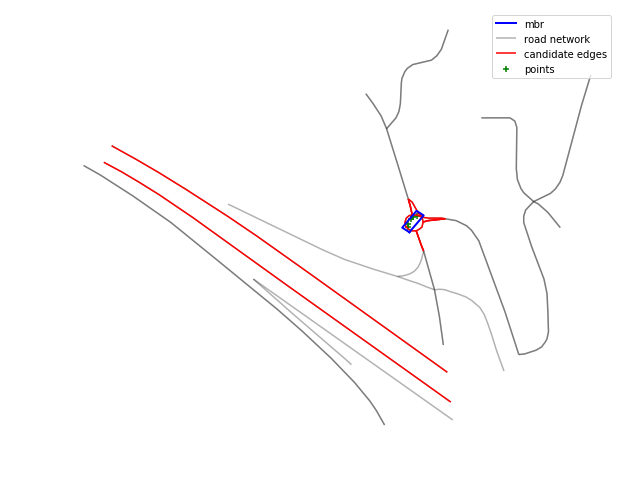

In [168]:
%matplotlib inline
def visualize_query_results(edges_gpd, gps_track, cluster, d_error):
    import matplotlib.pyplot as plt
    # prepare data
    segment = gps_track.iloc[cluster]
    c1 = segment.iloc[0]['geometry'].buffer(d_error).exterior
    c2 = segment.iloc[-1]['geometry'].buffer(d_error).exterior
    mbr = c1.union(c2).minimum_rotated_rectangle
    query_results = edges_gpd.iloc[list(edges_gpd.sindex.intersection(mbr.bounds, objects='raw'))]
    context_edges = edges_gpd.iloc[list(edges_gpd.sindex.intersection(mbr.buffer(250).bounds, objects='raw'))]
    #line = LineString(list(segment['geometry']))
    # ploting
    fig, ax = plt.subplots(figsize=(10,8))
    context_edges.plot(ax=ax, color='black', label='road network', alpha=0.3)
    query_results.plot(ax=ax, color='red', label = 'candidate edges')
    x,y = mbr.boundary.xy
    ax.plot(x,y, color='blue', alpha=1, linewidth=2, label='mbr', zorder=3)
    segment.plot(ax=ax, color='green', marker='+', label='points', alpha=1)
    ax.axis('off')
    ax.get_legend_handles_labels()
    ax.legend()
    return ax

visualize_query_results(edges_gpd, gps_track, clusters[67], 10)


In [177]:
candidates_v3.iloc[33]

mbr                 POLYGON ((-13590931.58091193 6014367.658346823...
mbr_heading                                                   306.592
candidate_edges                                  ([172685], [219340])
candidate_routes                                 [[172685], [219340]]
obs_prob                             [0.955945634081, 0.995510496346]
pre_cluster                                                        32
tran_routes                                        [[[172685]], [[]]]
tran_prob                                 [[0.370042257636], [1e-07]]
distances           [[(1322.29725651, 489.305862063)], [(1322.2972...
Name: 33, dtype: object

In [46]:
query_edges_by_point_range(edges_gpd, gps_track.iloc[clusters[19][-1]]['geometry'], 10)

[]

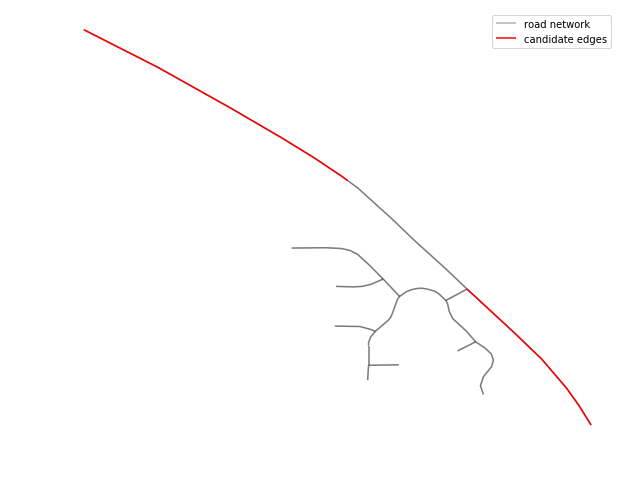

In [182]:
def visualize_query_edges(edges_gpd, gps_track, cluster, d_error, candi_edges):
    import matplotlib.pyplot as plt
    # prepare data
    segment = gps_track.iloc[cluster]
    c1 = segment.iloc[0]['geometry'].buffer(d_error).exterior
    c2 = segment.iloc[-1]['geometry'].buffer(d_error).exterior
    mbr = c1.union(c2).minimum_rotated_rectangle
    #query_results = edges_gpd.iloc[list(edges_gpd.sindex.intersection(mbr.bounds, objects='raw'))]
    query_results = edges_gpd.iloc[candi_edges]
    context_edges = edges_gpd.iloc[list(edges_gpd.sindex.intersection(mbr.buffer(50).bounds, objects='raw'))]
    line = LineString(list(segment['geometry']))
    # ploting
    fig, ax = plt.subplots(figsize=(10,8))
    context_edges.plot(ax=ax, color='black', label='road network', alpha=0.3)
    query_results.plot(ax=ax, color='red', label = 'candidate edges')
    x,y = mbr.boundary.xy
    #ax.plot(x,y, color='blue', alpha=1, linewidth=2, label='mbr', zorder=3)
    #segment.plot(ax=ax, color='green', marker='+', label='points', alpha=1)
    ax.axis('off')
    ax.get_legend_handles_labels()
    ax.legend()
    return ax

visualize_query_edges(edges_gpd, gps_track, clusters[33], 20, [172685, 219340]) # 220770,220754, 220760
# candidate_edges[1]

In [144]:
edges_gpd.iloc[220774]['geometry'].coords[0], edges_gpd.iloc[220774]['geometry'].coords[-1]

((-13592047.298777074, 6003516.162034566),
 (-13592027.293773687, 6003372.784190926))

In [142]:
edges_gpd.iloc[220772]['geometry'].coords[0], edges_gpd.iloc[220772]['geometry'].coords[-1]

((-13592027.293773687, 6003372.784190926),
 (-13592010.573173732, 6003224.997233943))

In [143]:
edges_gpd.iloc[220770]['geometry'].coords[0], edges_gpd.iloc[220770]['geometry'].coords[-1]

((-13592010.573173732, 6003224.997233943),
 (-13592002.81003798, 6003150.884138167))

In [145]:
edges_gpd.iloc[220774]['from'], edges_gpd.iloc[220774]['to']

(884148400391, 884148400875)

In [146]:
edges_gpd.iloc[220772]['from'], edges_gpd.iloc[220772]['to']

(884148400875, 884148400874)

In [147]:
edges_gpd.iloc[220770]['from'], edges_gpd.iloc[220770]['to']

(884148400336, 884148400866)

In [149]:
edges_gpd.iloc[220770]['geometry'].coords[0] == edges_gpd.iloc[220772]['geometry'].coords[-1], edges_gpd.iloc[220770]['from'] == edges_gpd.iloc[220772]['to']

(True, False)

In [155]:
query_edges_by_point_range(edges_gpd, Point(edges_gpd.iloc[220772]['geometry'].coords[-1]), 20)

[220770, 220769, 220772, 220771, 219874, 219815]

In [175]:
query_edges_by_point_range(edges_gpd, gps_track.iloc[clusters[67][0]]['geometry'], 20)

[222445, 222447, 223665, 223664, 222446, 222438, 222437, 222436]

In [178]:
calculate_shortest_path(road_graph, edges_gpd, 172685, 219340)

No path to 884148400031.


[]